## Analyzing Raw Data

In [1]:
## Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

# PRESSURE_PATH = '/home/ubuntu/CAAM/496_New_Data/saturation/'   # pressure data
SATURATION_PATH = '/home/ubuntu/CAAM/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/home/ubuntu/CAAM/496_New_Data/production/' # production data

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    print('Pulling '+NAME+'...\n')
    data = []
    for i in index_list:
        print(str(i)+'.\t')
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


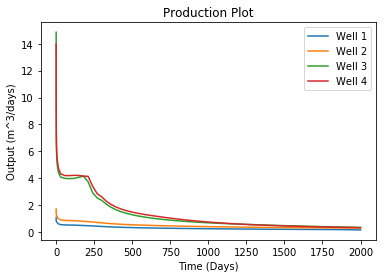

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

## Autoencoders

In [3]:
# %matplotlib notebook
# pull saturation data, 30 examples total
STRAIN = pullseries(SATURATION_PATH, 'saturaton', np.arange(1,81))
STEST = pullseries(SATURATION_PATH, 'saturaton', np.arange(81,101))
# PTRAIN = pullseries(PRESSURE_PATH, 'pressure', np.arange(1,3))

# Strain, Sscaler = scale_data(STRAIN)
# Stest = Sscaler.transform(STEST)
Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')
print(Strain_reshaped.dtype)
print(Strain_reshaped.shape)

Pulling saturaton...

1.	
2.	
3.	
4.	
5.	
6.	
7.	
8.	
9.	
10.	
11.	
12.	
13.	
14.	
15.	
16.	
17.	
18.	
19.	
20.	
21.	
22.	
23.	
24.	
25.	
26.	
27.	
28.	
29.	
30.	
31.	
32.	
33.	
34.	
35.	
36.	
37.	
38.	
39.	
40.	
41.	
42.	
43.	
44.	
45.	
46.	
47.	
48.	
49.	
50.	
51.	
52.	
53.	
54.	
55.	
56.	
57.	
58.	
59.	
60.	
61.	
62.	
63.	
64.	
65.	
66.	
67.	
68.	
69.	
70.	
71.	
72.	
73.	
74.	
75.	
76.	
77.	
78.	
79.	
80.	
Pulling saturaton...

81.	
82.	
83.	
84.	
85.	
86.	
87.	
88.	
89.	
90.	
91.	
92.	
93.	
94.	
95.	
96.	
97.	
98.	
99.	
100.	
float32
(6000, 60, 220, 1)


In [4]:
print(Strain_reshaped.shape)
print(Stest_reshaped.shape)
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# plt.ion()
# fig.show()
# ax1.imshow(Strain_reshaped[72,:,:,0])

(6000, 60, 220, 1)
(1500, 60, 220, 1)


In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(60, 220, 1))  # y, x

x = Conv2D(16, (6, 22), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# encoded space (8,28,8)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (6, 22), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

encoder = Model(input_img, encoded)
# encoder.summary()

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(8,28,8))
deco = autoencoder.layers[-7](encoded_input)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
# decoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 220, 16)       2128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 110, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 110, 8)        1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 55, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 55, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 28, 8)          0         
__________

In [6]:
from keras.callbacks import TensorBoard
autoencoder.fit(Strain_reshaped, Strain_reshaped,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(Stest_reshaped, Stest_reshaped),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 6000 samples, validate on 1500 samples
Epoch 1/50
6000/6000 [==============================] - 39s 6ms/step - loss: 0.0130 - val_loss: 0.0033
Epoch 2/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/50
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/50
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/50
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/50
6000/6000 [==

In [17]:
from keras.models import load_model
#Save partly trained model
autoencoder.save('trained_autoencoder.h5')

In [16]:
from keras.models import load_model
#Save partly trained model
autoencoder.save('trained_autoencoder.h5')
del autoencoder
#Reload model
autoencoder = load_model('trained_autoencoder.h5')
autoencoder.fit(Strain_reshaped, Strain_reshaped,
                epochs=10,
                batch_size=25,
                shuffle=True,
                validation_data=(Stest_reshaped, Stest_reshaped),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 12s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 2/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/10
6000/6000 [==============================] - 11s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
6000/6000 [==

In [13]:
# test encoding
encoded_series = encoder.predict(Stest_reshaped[0:75,])

array([[[0.11431943, 0.18226689, 0.10987814, ..., 0.15872395,
         0.06879247, 0.11833477],
        [0.11424735, 0.16049805, 0.14207688, ..., 0.16401953,
         0.05933562, 0.05631026],
        [0.12074143, 0.15614262, 0.13468212, ..., 0.16612437,
         0.0599038 , 0.06202715],
        ...,
        [0.1245977 , 0.16821676, 0.14152671, ..., 0.16639905,
         0.0620409 , 0.06968659],
        [0.11297165, 0.17602655, 0.13141622, ..., 0.16201861,
         0.04230217, 0.0682518 ],
        [0.12444445, 0.07980412, 0.08391629, ..., 0.11611371,
         0.05196818, 0.03680619]],

       [[0.13553031, 0.09381741, 0.11570305, ..., 0.07490979,
         0.09362996, 0.06984642],
        [0.12752362, 0.09368864, 0.1159018 , ..., 0.11597201,
         0.09151471, 0.04588331],
        [0.13015415, 0.08904547, 0.11560734, ..., 0.1164259 ,
         0.08564108, 0.03735624],
        ...,
        [0.13045086, 0.09745029, 0.12432314, ..., 0.11560027,
         0.08787537, 0.03745386],
        [0.1

<IPython.core.display.Javascript object>


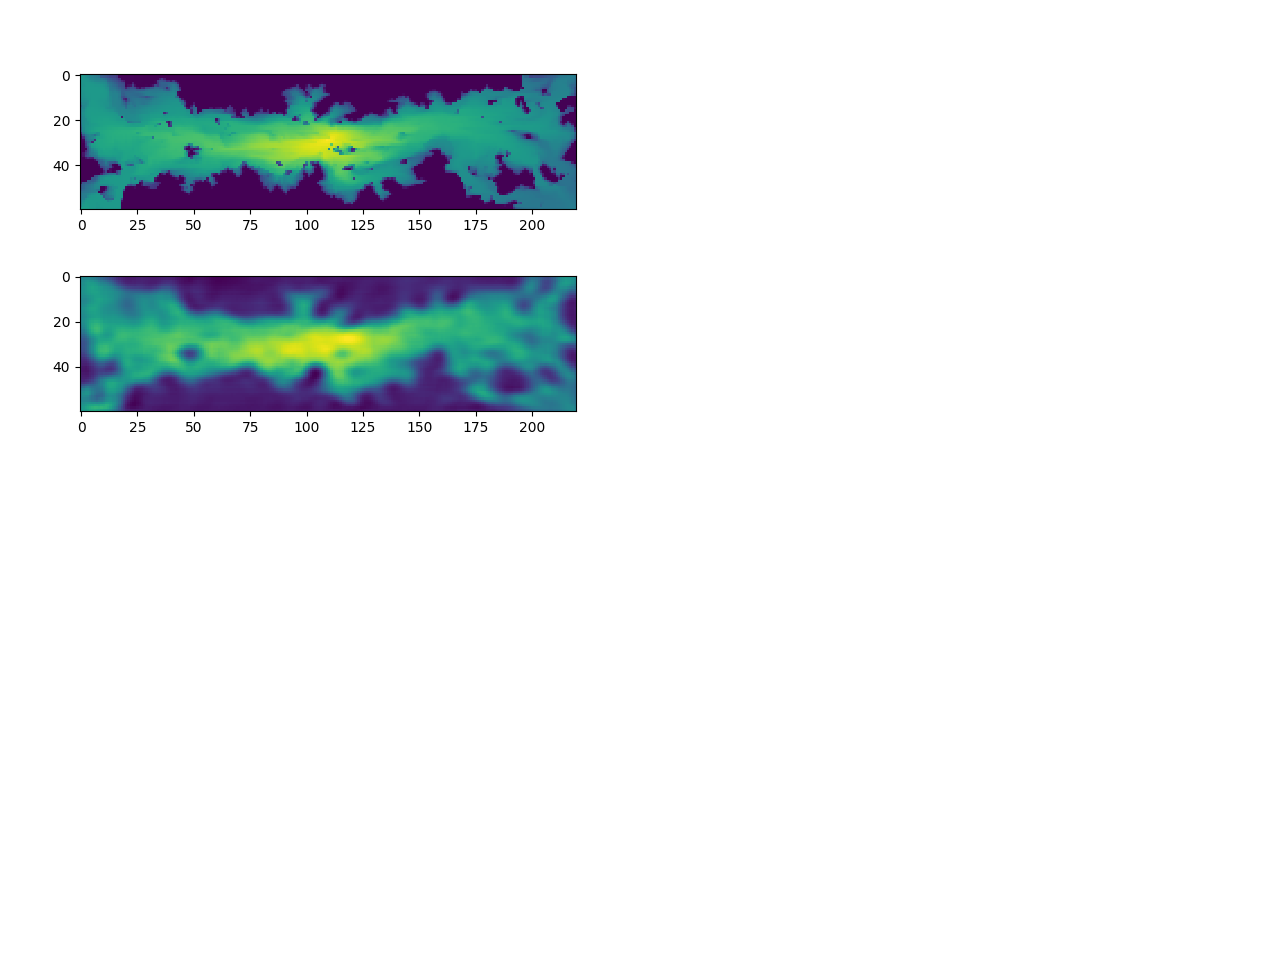

In [11]:
%matplotlib notebook
decoded_Saturation = autoencoder.predict(Stest_reshaped[150:375,])
animate_compare(Stest_reshaped[150:375,],decoded_Saturation[:,])

## Scale data and split into sequences for RNN

In [9]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(DATA,window_len):
    """
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    """
    X_new = []
    y_new = DATA[window_len:]
    for index in range(len(DATA) - window_len):        
        temp = DATA[index]
        for i in range(1,window_len):
            temp = np.vstack((temp,DATA[index+i]))
        X_new.append(temp)
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

def scale_data(X):
    # input original dataset samples X (x*y)
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
    normalized = scaler.transform(X)
    return normalized, scaler

def prepare_RNNtraining_data(TRAIN,lookback):
    # train the standardization
    Out_X = []
    Out_y = []
    for i in range(int(len(normalized)/75)):
        X_temp, y_temp = create_dataset(normalized[i*75:(i+1)*75,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)

def prepare_RNNtesting_data(TEST,lookback):
    # train the standardization
    Out_X = []
    Out_y = []
    for i in range(int(len(normalized)/75)):
        X_temp, y_temp = create_dataset(normalized[i*75:(i+1)*75,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)




## LSTM-RNN

In [31]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,TRAIN,TEST,LSTM_unit):
    # specify Neural Network architecture
#     Dense1_unit = 100
#     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    n = X_train.shape[2] # size of input
    if lookback == 1:
        # change expected output shape if lookback is 1
        X_train = np.expand_dims(X_train,axis = 1)
        y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    model = Sequential()
#     model.add(Dense1_unit,(lookback,n))
#     model.add(Reshape((3, 4), input_shape=(Dense1_unit,)))
    model.add(LSTM(LSTM_unit, activation='relu', input_shape=(lookback, n)))
    model.add(Dense((n)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=20, batch_size=75-lookback, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    model.summary()
    return model

## Sequential States Test

In [32]:
from numpy import linalg as LA
def updateX(model,X_current,lookback):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
    X_c_train = np.expand_dims(X_current, axis=0)
    x_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    if lookback == 1:
        X_next = x_plusone
    else:
        X_next = np.vstack((X_current[1:,],x_plusone))
    return X_next,x_plusone

def cumulative_test(TEST,lookback,model,scaler):
    # perform cumulative testing
    X_test, y_test = TEST
    X_current = X_test[0,] # both X_test should be the same
    m = y_test.shape[0]
    i = 0
    errors = np.zeros(m)
    predicted_y = np.zeros(y_test.shape)
    while i < m:
        X_next,y_predicted = updateX(model,X_current,lookback)
        # rescale, optional
        y_test_rescaled = scaler.inverse_transform(y_test)
        y_predicted_rescaled = scaler.inverse_transform(y_predicted)
        # update X and error term
        X_current = X_next
        errors[i] = LA.norm(y_test_rescaled-y_predicted_rescaled)/LA.norm(y_test_rescaled)
        predicted_y[i,:] = y_predicted_rescaled
        i += 1
    return errors, predicted_y

In [10]:
# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)

## Saturation Test

In [26]:
np.arange(21,31)

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

Min: [0.20056 0.20004 0.19943] 
Max:  [0.53692 0.53385 0.53142]


<IPython.core.display.Javascript object>


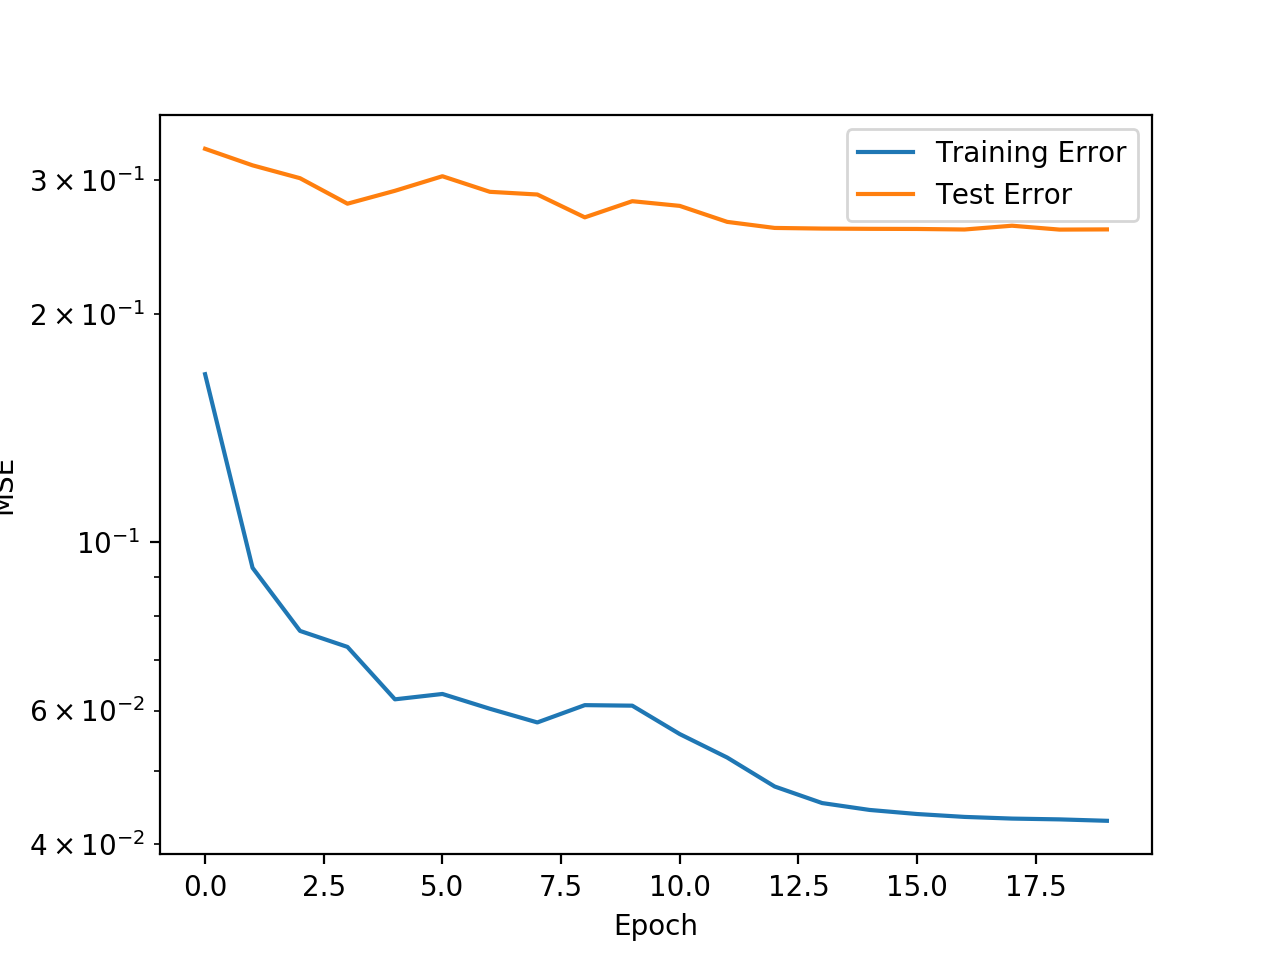

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                2650200   
_________________________________________________________________
dense_5 (Dense)              (None, 13200)             673200    
Total params: 3,323,400
Trainable params: 3,323,400
Non-trainable params: 0
_________________________________________________________________


In [34]:

%matplotlib notebook
STRAIN = pullseries(SATURATION_PATH, 'saturaton', np.arange(1,21))
STEST = pullseries(SATURATION_PATH, 'saturaton', np.arange(21,31))
lookback = 3
Strain,Sscaler = prepare_training_data(STRAIN,lookback)
Stest = prepare_testing_data(STEST,lookback,Sscaler)
Smodel = trainRNN(lookback,Strain,Stest,50)

In [35]:
# errors, predicted_y = cumulative_test(Stest,lookback,Smodel,Sscaler)
errors, predicted_y = cumulative_test(Stest,lookback,Smodel,Sscaler)
animate_compare(predicted_y,STEST[lookback:])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: ove

ValueError: Input contains infinity or a value too large for dtype('float32').

## Pressure Test

Min: [27586000. 27617000. 27657000.] 
Max:  [30156000. 34839000. 36236000.]


<IPython.core.display.Javascript object>


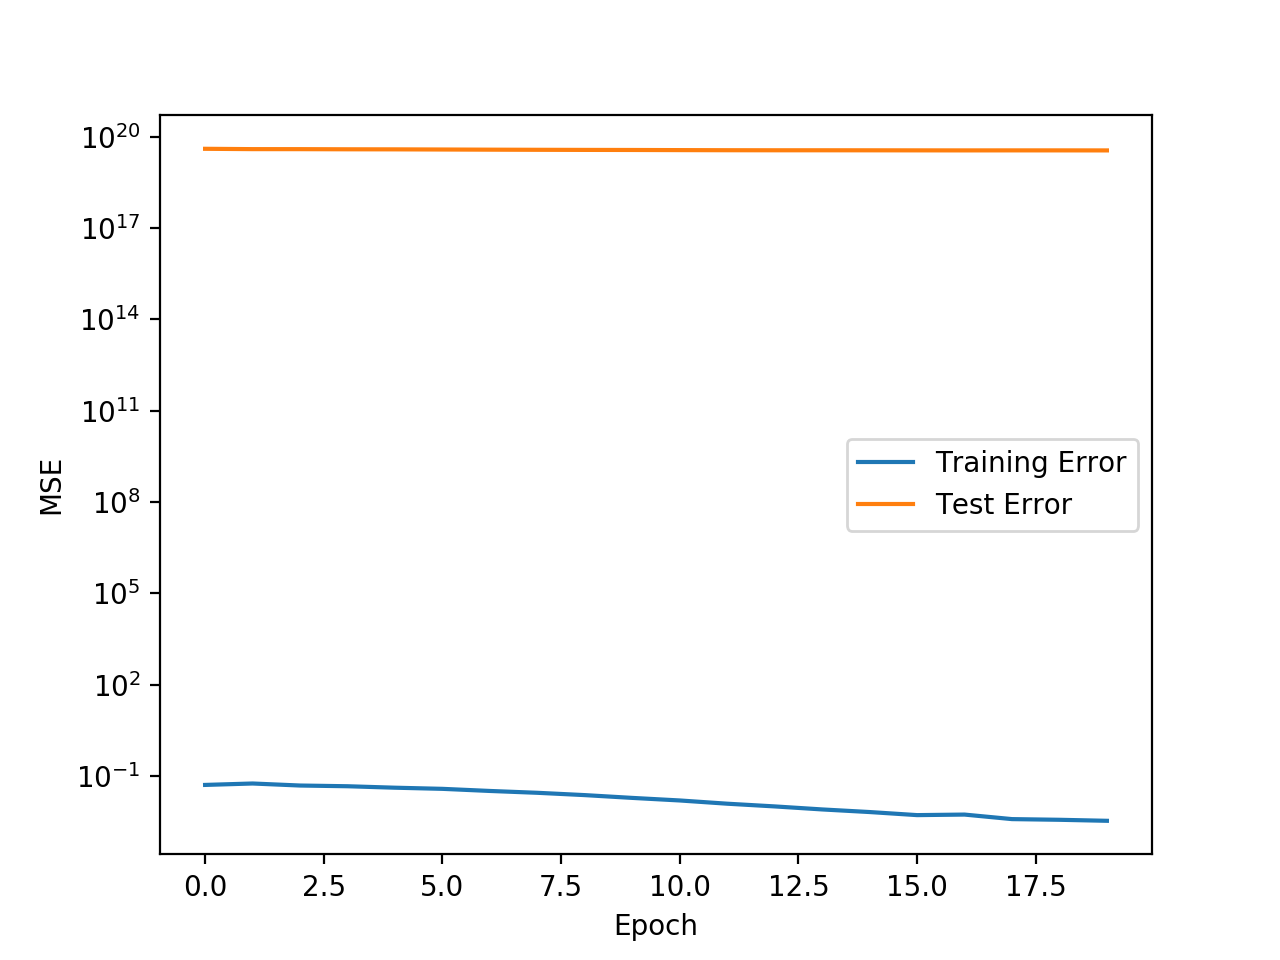

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                2650200   
_________________________________________________________________
dense_4 (Dense)              (None, 13200)             673200    
Total params: 3,323,400
Trainable params: 3,323,400
Non-trainable params: 0
_________________________________________________________________


In [23]:
PTRAIN = pullseries(PRESSURE_PATH, 'pressure', [1, 2])
PTEST = pullseries(PRESSURE_PATH, 'pressure', [3])
lookback = 3
Ptrain,Pscaler = prepare_training_data(PTRAIN,lookback)
Ptest = prepare_testing_data(PTEST,lookback,Sscaler)
Pmodel = trainRNN(lookback,Ptrain,Ptest,50)

<IPython.core.display.Javascript object>


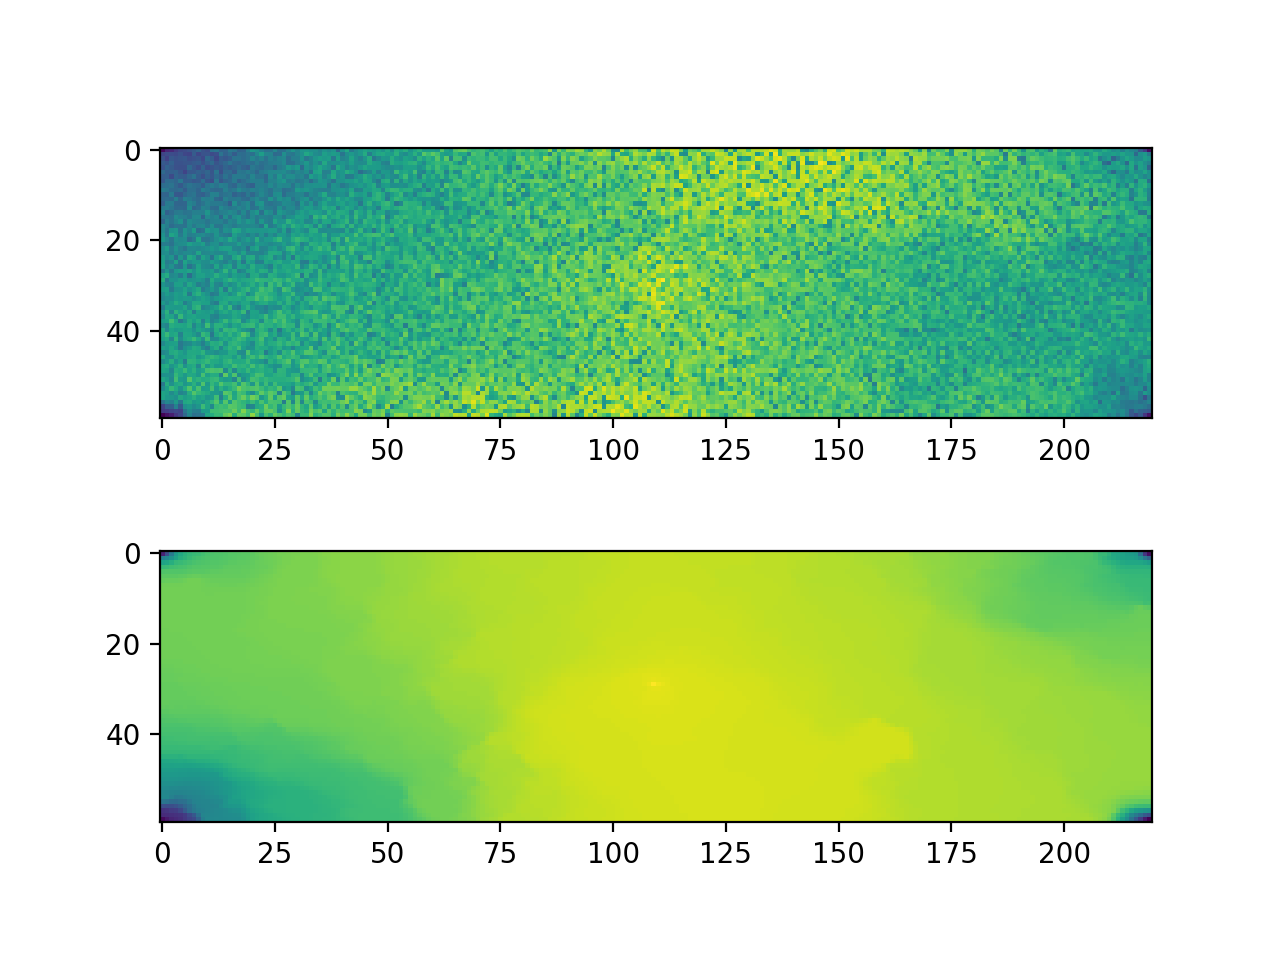

<IPython.core.display.Javascript object>


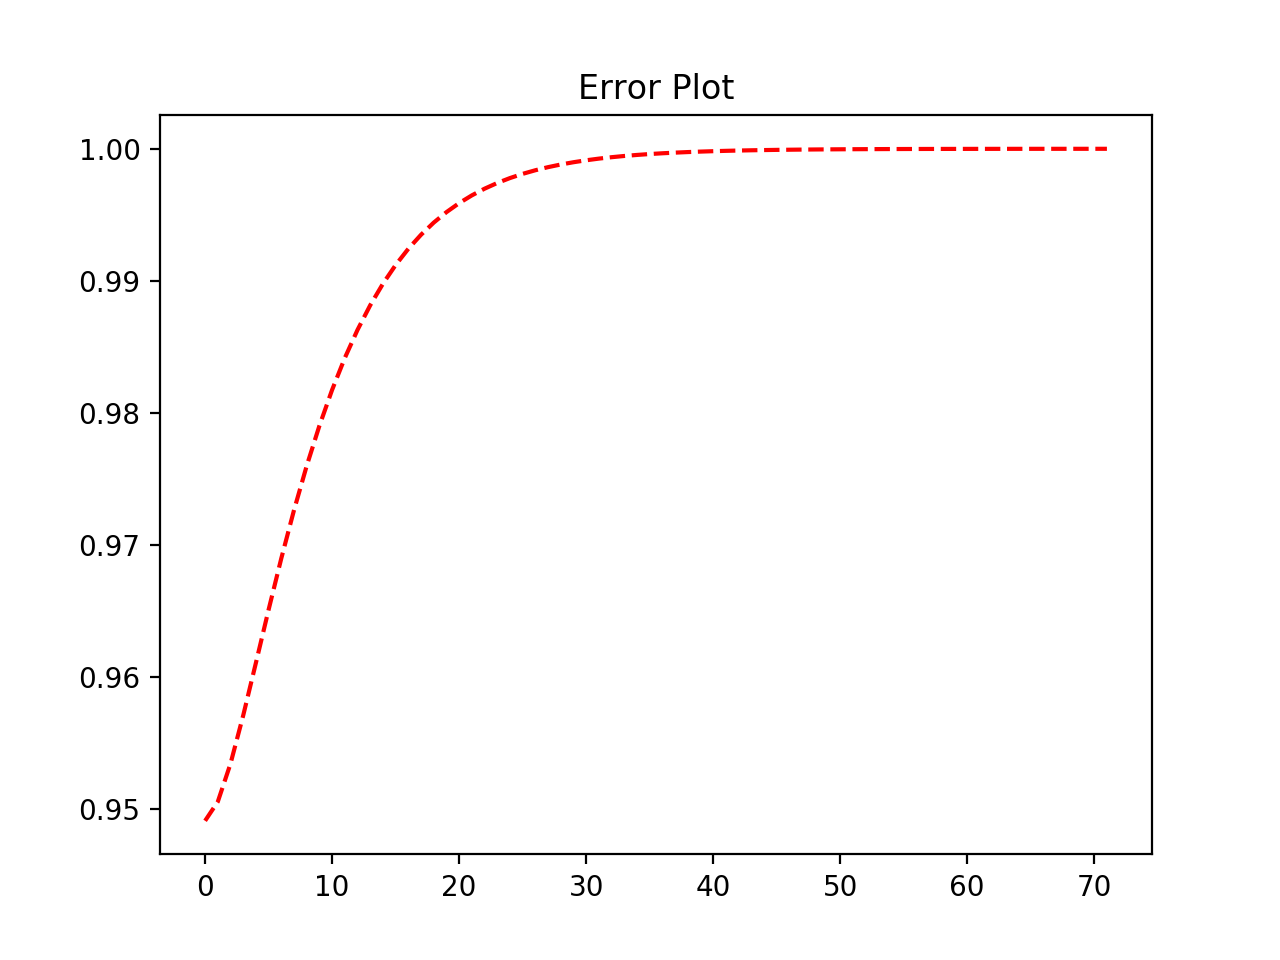

In [24]:
errors, predicted_y = cumulative_test(Ptest,lookback,Pmodel,Pscaler)
animate_compare(predicted_y,PTEST[lookback:])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')